# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from tqdm import tqdm

from IPython.display import clear_output

from random import randint

In [2]:
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/01b_autoencoder'

# Loading data

In [4]:
path_to_data = './../data/ftir_scaled_train.csv'
path_to_description = './../data/ftir_description.csv'

## Scaled spectra

In [5]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Data wrangling

In [7]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [8]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

# Data processing

## Augmentation

In [9]:
path_to_augmented_data = './../data'

In [10]:
%%time

if 'augmented_data.csv' in os.listdir(path_to_augmented_data):
    data_aug = pd.read_csv(f'{path_to_augmented_data}/augmented_data.csv')
    if 'Unnamed: 0' in data_aug.columns:
        data_aug = data_aug.drop(columns=['Unnamed: 0'])
else:
    # base parameters for augmentation
    aug_factor = 100
    min_sigma = 5e-4
    max_sigma = 1e-2

    # data augmentation
    data_aug = data.copy()
    for idx in tqdm(data.index):
        spectrum = data.loc[idx]
        sigma_values = np.linspace(min_sigma, max_sigma, aug_factor)
        for sigma in sigma_values:
            noised_spectrum = pd.DataFrame(spectrum + np.random.normal(0, sigma, spectrum.shape[0]))
            data_aug = pd.concat([data_aug, noised_spectrum.T], axis=0)

    # scaling
    scaler = MinMaxScaler()
    data_aug = pd.DataFrame(scaler.fit_transform(data_aug.T).T)

    # data_aug.to_csv(f'{path_to_augmented_data}/augmented_data.csv')

print(data_aug.shape)
data_aug.sample(3)

100%|███████████████████████████████████████████| 25/25 [00:06<00:00,  3.71it/s]

(2525, 1142)
CPU times: user 3.05 s, sys: 3.71 s, total: 6.75 s
Wall time: 6.79 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
555,0.008705,0.009958,0.006371,0.011350,0.005144,0.008175,0.000000,0.005445,0.011868,0.010422,0.006147,0.006029,0.007698,0.006160,0.007421,0.007438,0.011380,0.004580,0.012805,0.015925,0.008477,0.008219,0.008043,0.011574,0.013687,...,0.074583,0.070520,0.071218,0.062272,0.067790,0.065946,0.067384,0.064133,0.056897,0.058803,0.050046,0.048489,0.051945,0.041341,0.046816,0.037481,0.040704,0.037171,0.042558,0.037625,0.035127,0.040863,0.037477,0.034497,0.037624
2153,0.001273,0.000000,0.001614,0.011778,0.006793,0.007736,0.007974,0.010803,0.007024,0.014117,0.011489,0.009704,0.012119,0.008738,0.011509,0.006785,0.013929,0.014367,0.013988,0.015648,0.015209,0.011811,0.008842,0.007208,0.015273,...,0.034869,0.030995,0.036594,0.036366,0.033671,0.030344,0.028609,0.026046,0.025544,0.026577,0.026106,0.029255,0.025384,0.023873,0.022764,0.018731,0.019814,0.016479,0.021698,0.017451,0.016506,0.015610,0.014425,0.013795,0.014833
2052,0.016551,0.015850,0.019453,0.014769,0.017180,0.013850,0.009549,0.017708,0.012795,0.011079,0.011741,0.013605,0.011912,0.013383,0.009170,0.014067,0.015588,0.013806,0.008457,0.006848,0.010220,0.009372,0.009411,0.018230,0.009942,...,0.038249,0.032654,0.026818,0.033591,0.029784,0.033716,0.032276,0.032793,0.025456,0.026185,0.026126,0.023094,0.019202,0.020986,0.025459,0.021395,0.015812,0.016232,0.019292,0.014924,0.018754,0.014405,0.013625,0.019412,0.012644


## Splitting dataset to *train/validation*

In [11]:
train_data, val_data = train_test_split(data_aug, test_size=0.2)

print(train_data.shape, val_data.shape, sep='\n')

(2020, 1142)
(505, 1142)


## Creating *torch tensor* & *torch dataset*

In [12]:
go_data_torch = torch.Tensor([go_data.to_numpy()])
god_data_torch = torch.Tensor([god_data.to_numpy()])
rgo_data_torch = torch.Tensor([rgo_data.to_numpy()])

train_data_torch = torch.Tensor([train_data.to_numpy()])
val_data_torch = torch.Tensor([val_data.to_numpy()])

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([1, 2020, 1142])
torch.Size([1, 505, 1142])


In [13]:
go_data_torch = go_data_torch.permute(1, 0, 2)
god_data_torch = god_data_torch.permute(1, 0, 2)
rgo_data_torch = rgo_data_torch.permute(1, 0, 2)

train_data_torch = train_data_torch.permute(1, 0, 2)
val_data_torch = val_data_torch.permute(1, 0, 2)

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([2020, 1, 1142])
torch.Size([505, 1, 1142])


In [14]:
train_dataset = TensorDataset(train_data_torch, train_data_torch)
val_dataset = TensorDataset(val_data_torch, val_data_torch)

## Creating *dataloader*

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

# Autoencoder model

## Encoder block

In [16]:
def encoder_block(in_channels, out_channels, kernel_size, padding):
    block = nn.Sequential(
        nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
        ),
        nn.Sigmoid(),
        nn.MaxPool1d(kernel_size=2)
    )
    return block

## Decoder block

In [17]:
def decoder_block(in_channels, out_channels, kernel_size, padding):
    block = nn.Sequential(
        nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
        ),
        nn.Sigmoid(),
        nn.Upsample(scale_factor=2, mode='linear')
    )
    return block

## Autoencoder class

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.encoder = nn.Sequential(
            encoder_block(in_channels=1, out_channels=2, kernel_size=3, padding=1),  # 1142 --> 571
            encoder_block(in_channels=2, out_channels=4, kernel_size=2, padding=1),  # 571 --> 286
            encoder_block(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 286 --> 143
        )
        self.decoder = nn.Sequential(
            decoder_block(in_channels=8, out_channels=4, kernel_size=3, padding=1),  # 143 --> 286
            decoder_block(in_channels=4, out_channels=2, kernel_size=2, padding=0),  # 286 --> 570
            decoder_block(in_channels=2, out_channels=1, kernel_size=2, padding=1)  # 570 --> 1142
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

# Training model & visualization

## Function for training

In [19]:
def train(model, train_loader, val_loader, loss_function, optimizer, X, plot_every_n_epoch=50, n_epochs=100, stop_criteria=None, path_to_save=None):
    
    epochs = []
    losses_train = []
    losses_val = []
    early_stopping_epoch = None  

    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train_lst = []

        for x_batch, y_batch in train_loader:
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train_lst.append(loss.item())

        losses_train.append(np.mean(loss_train_lst))

        model.eval()
        losses_val.append(np.mean([
            loss_function(model(batch[0])[0], batch[1]).item()
            for batch in val_loader
        ]))
        
        epochs.append(epoch)

        # Early stopping condition
        if stop_criteria and len(losses_val) > 10:
            if abs(losses_val[-1] - losses_val[-10]) <= stop_criteria:
                early_stopping_epoch = epoch
                break
        
        if epoch % plot_every_n_epoch == 0 or epoch == n_epochs:
            clear_output(wait=True)

            sns.set_theme()
            fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), dpi=300)

            # Mse-loss visualization
            ax = axes[0]
            
            ax.plot(epochs, losses_train, marker='s', color='purple', linewidth=2.0, alpha=0.6, label='Обучающая')
            ax.plot(epochs, losses_val, marker='s', color='sienna', linewidth=2.0, alpha=0.6, label='Валидационная')
            
            ax.set_xlabel('Число эпох обучения', fontsize=16)  # Epochs
            ax.set_ylabel('$MSE_{avg}$', fontsize=16)
            
            ax.tick_params(axis='both', labelsize=14)
            
            ax.legend(title='Тип выборки', title_fontsize=12, fontsize=11)

            # Spectra visualization
            ax = axes[1]
            
            with torch.no_grad():
                x_batch = next(iter(val_loader))[0]  # first batch
                
                rng = np.random.default_rng(42)
                batch_index = rng.integers(0, x_batch.shape[0])

                real_target = x_batch[batch_index][0].detach().cpu().numpy()
                reconstructed = model(x_batch)[0][batch_index][0].detach().cpu().numpy()

            ax.plot(X, real_target, linestyle='-', color='tan', linewidth=2.5, label='Исходный')
            ax.plot(X, reconstructed, linestyle='-', color='cadetblue', linewidth=2.5, label='Восстановленный')

            ax.set_xlabel('Волновое число, см$^{-1}$', fontsize=16)
            ax.set_ylabel('$A_{n}$', fontsize=16, rotation=0, labelpad=15)

            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

            ax.set_xticks(np.linspace(1900, 800, 6))
            
            ax.tick_params(axis='both', labelsize=14)
            
            ax.invert_xaxis()
            
            ax.legend(title='ИК-спектр', title_fontsize=12, fontsize=11)

            plt.tight_layout()
            if epoch == n_epochs and path_to_save:
                plt.savefig(path_to_save, dpi=600)
            
            plt.show()
            plt.pause(0.001)
            plt.close(fig)

    if early_stopping_epoch:
        print(f'Early stopping at epoch {early_stopping_epoch} due to stabilization of validation loss.')

## Training

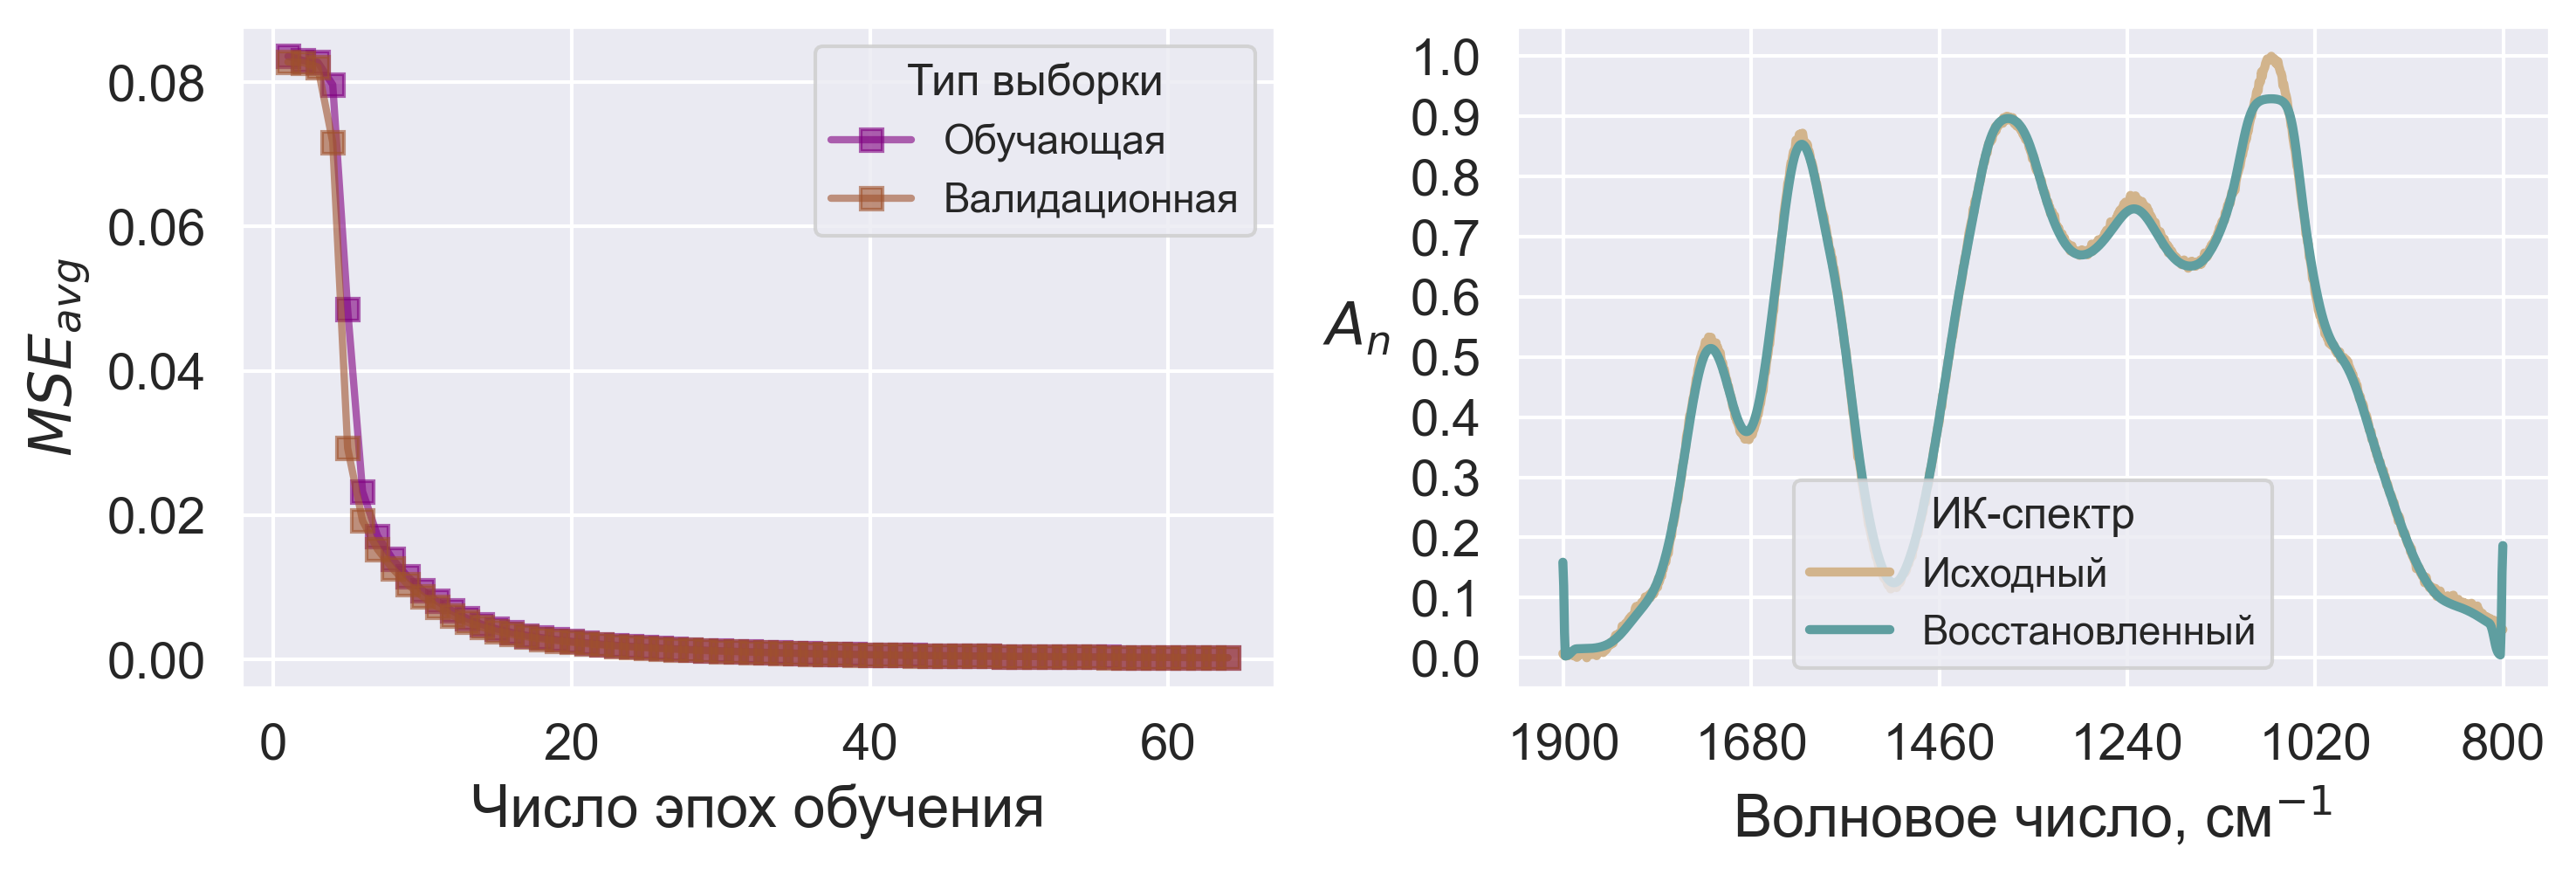

CPU times: user 3min 38s, sys: 55.1 s, total: 4min 33s
Wall time: 2min 41s


In [20]:
%%time

model = Autoencoder()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_function=loss_function,
    optimizer=optimizer,
    X=wavenumber, 
    plot_every_n_epoch=4,
    n_epochs=64,
    stop_criteria=None,
    path_to_save=f'{path_to_save}/nn_training_results.png'
)

# Clustering on spectra embeddings

## Base variables

In [21]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

In [22]:
FONT_SIZE_TITLE = 22
FONT_SIZE_XLABEL = 18
FONT_SIZE_YLABEL = 18
FONT_SIZE_XTICKS = 16
FONT_SIZE_YTICKS = 16

## Class for clustering on embeddings

In [23]:
class EmbeddingStructureAnalysis:
    def __init__(self, model):
        self.model = model

    def get_embedding(self, torch_data, original_data):
        _, embedding = self.model(torch_data)
        return pd.DataFrame(
            embedding.detach().cpu().numpy()[:, 0],
            index=original_data.index
        )

    def fit_transform_kmeans(self, embeddings, n_clusters, random_state=42):
        estimator = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
        estimator.fit(embeddings)

        self.n_clusters = len(set(estimator.labels_))
        self.embeddings = embeddings
        self.estimator = estimator
        self.cluster_centers = estimator.cluster_centers_

        predictions = pd.DataFrame(estimator.predict(embeddings), index=embeddings.index, columns=['Prediction'])
        self.train_data_predictions = pd.concat([embeddings, predictions], axis=1).sort_values(by='Prediction')

    def get_silhouette_score(self):
        return silhouette_score(self.embeddings, self.estimator.labels_) if self.n_clusters >= 2 else None

    def get_metrics_visualization(self, embeddings, max_n_clusters, ax, metric='silhouette', refit=False):
        n_clusters_arr = list(range(2, min(max_n_clusters, len(embeddings) - 1) + 1))
        metric_values = []
        original_n_clusters = self.n_clusters  # Сохраняем исходное число кластеров

        for n_clusters in tqdm(n_clusters_arr, desc=f'Computing {metric} values'):
            self.fit_transform_kmeans(embeddings, n_clusters)
            metric_values.append(self.get_silhouette_score() if metric == 'silhouette' else self.estimator.inertia_)

        sns.barplot(x=n_clusters_arr, y=metric_values, palette='viridis', ax=ax)
        
        ax.set_title('Зависимость silhouette score от числа кластеров', fontsize=FONT_SIZE_TITLE)
        
        ax.set_xlabel('Число кластеров', fontsize=FONT_SIZE_XLABEL)
        ax.set_ylabel('Silhouette score', fontsize=FONT_SIZE_YLABEL)
        
        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)

        if not refit:
            self.fit_transform_kmeans(embeddings, original_n_clusters)

    def get_spectra_clusters_visualization(self, original_data, wavenumber, axes, color):
        data_with_labels = self.train_data_predictions
        clustered_data = original_data.loc[data_with_labels.index]
    
        for cluster_id in range(self.n_clusters):
            ax = axes[cluster_id]
    
            temp_data = clustered_data[data_with_labels['Prediction'] == cluster_id].to_numpy()
    
            if len(temp_data) == 0:
                ax.axis("off")
                continue
    
            temp_centroid = np.mean(temp_data, axis=0)
    
            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=3.5, color=color, alpha=1.0)
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=4.0, color='black', alpha=0.7, label='Centroid')
    
            ax.set_title(f'Кластер №{cluster_id+1}', fontsize=FONT_SIZE_TITLE-4, fontweight='bold')
            
            ax.set_xlabel('Волновое число, см$^{-1}$', fontsize=FONT_SIZE_XLABEL)
            ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL, rotation=0, labelpad=20)

            # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
            
            ax.set_xticks(np.linspace(1900, 800, 6))
            
            ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
            ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
            
            ax.invert_xaxis()

## Clustering & Visualization

In [24]:
max_n_clusters = 10

embedding_go = EmbeddingStructureAnalysis(model).get_embedding(go_data_torch, go_data)
embedding_rgo = EmbeddingStructureAnalysis(model).get_embedding(rgo_data_torch, rgo_data)
embedding_god = EmbeddingStructureAnalysis(model).get_embedding(god_data_torch, god_data)

datasets = [
    ('$ОГ$', embedding_go, go_data, 'RoyalBlue', 4),
    ('$вОГ$', embedding_rgo, rgo_data, 'Goldenrod', 2),
    ('$ОГ_{диализ}$', embedding_god, god_data, 'SeaGreen', 3)
]

predictions_lst = []

Computing silhouette values: 100%|████████████████| 9/9 [00:00<00:00, 15.20it/s]


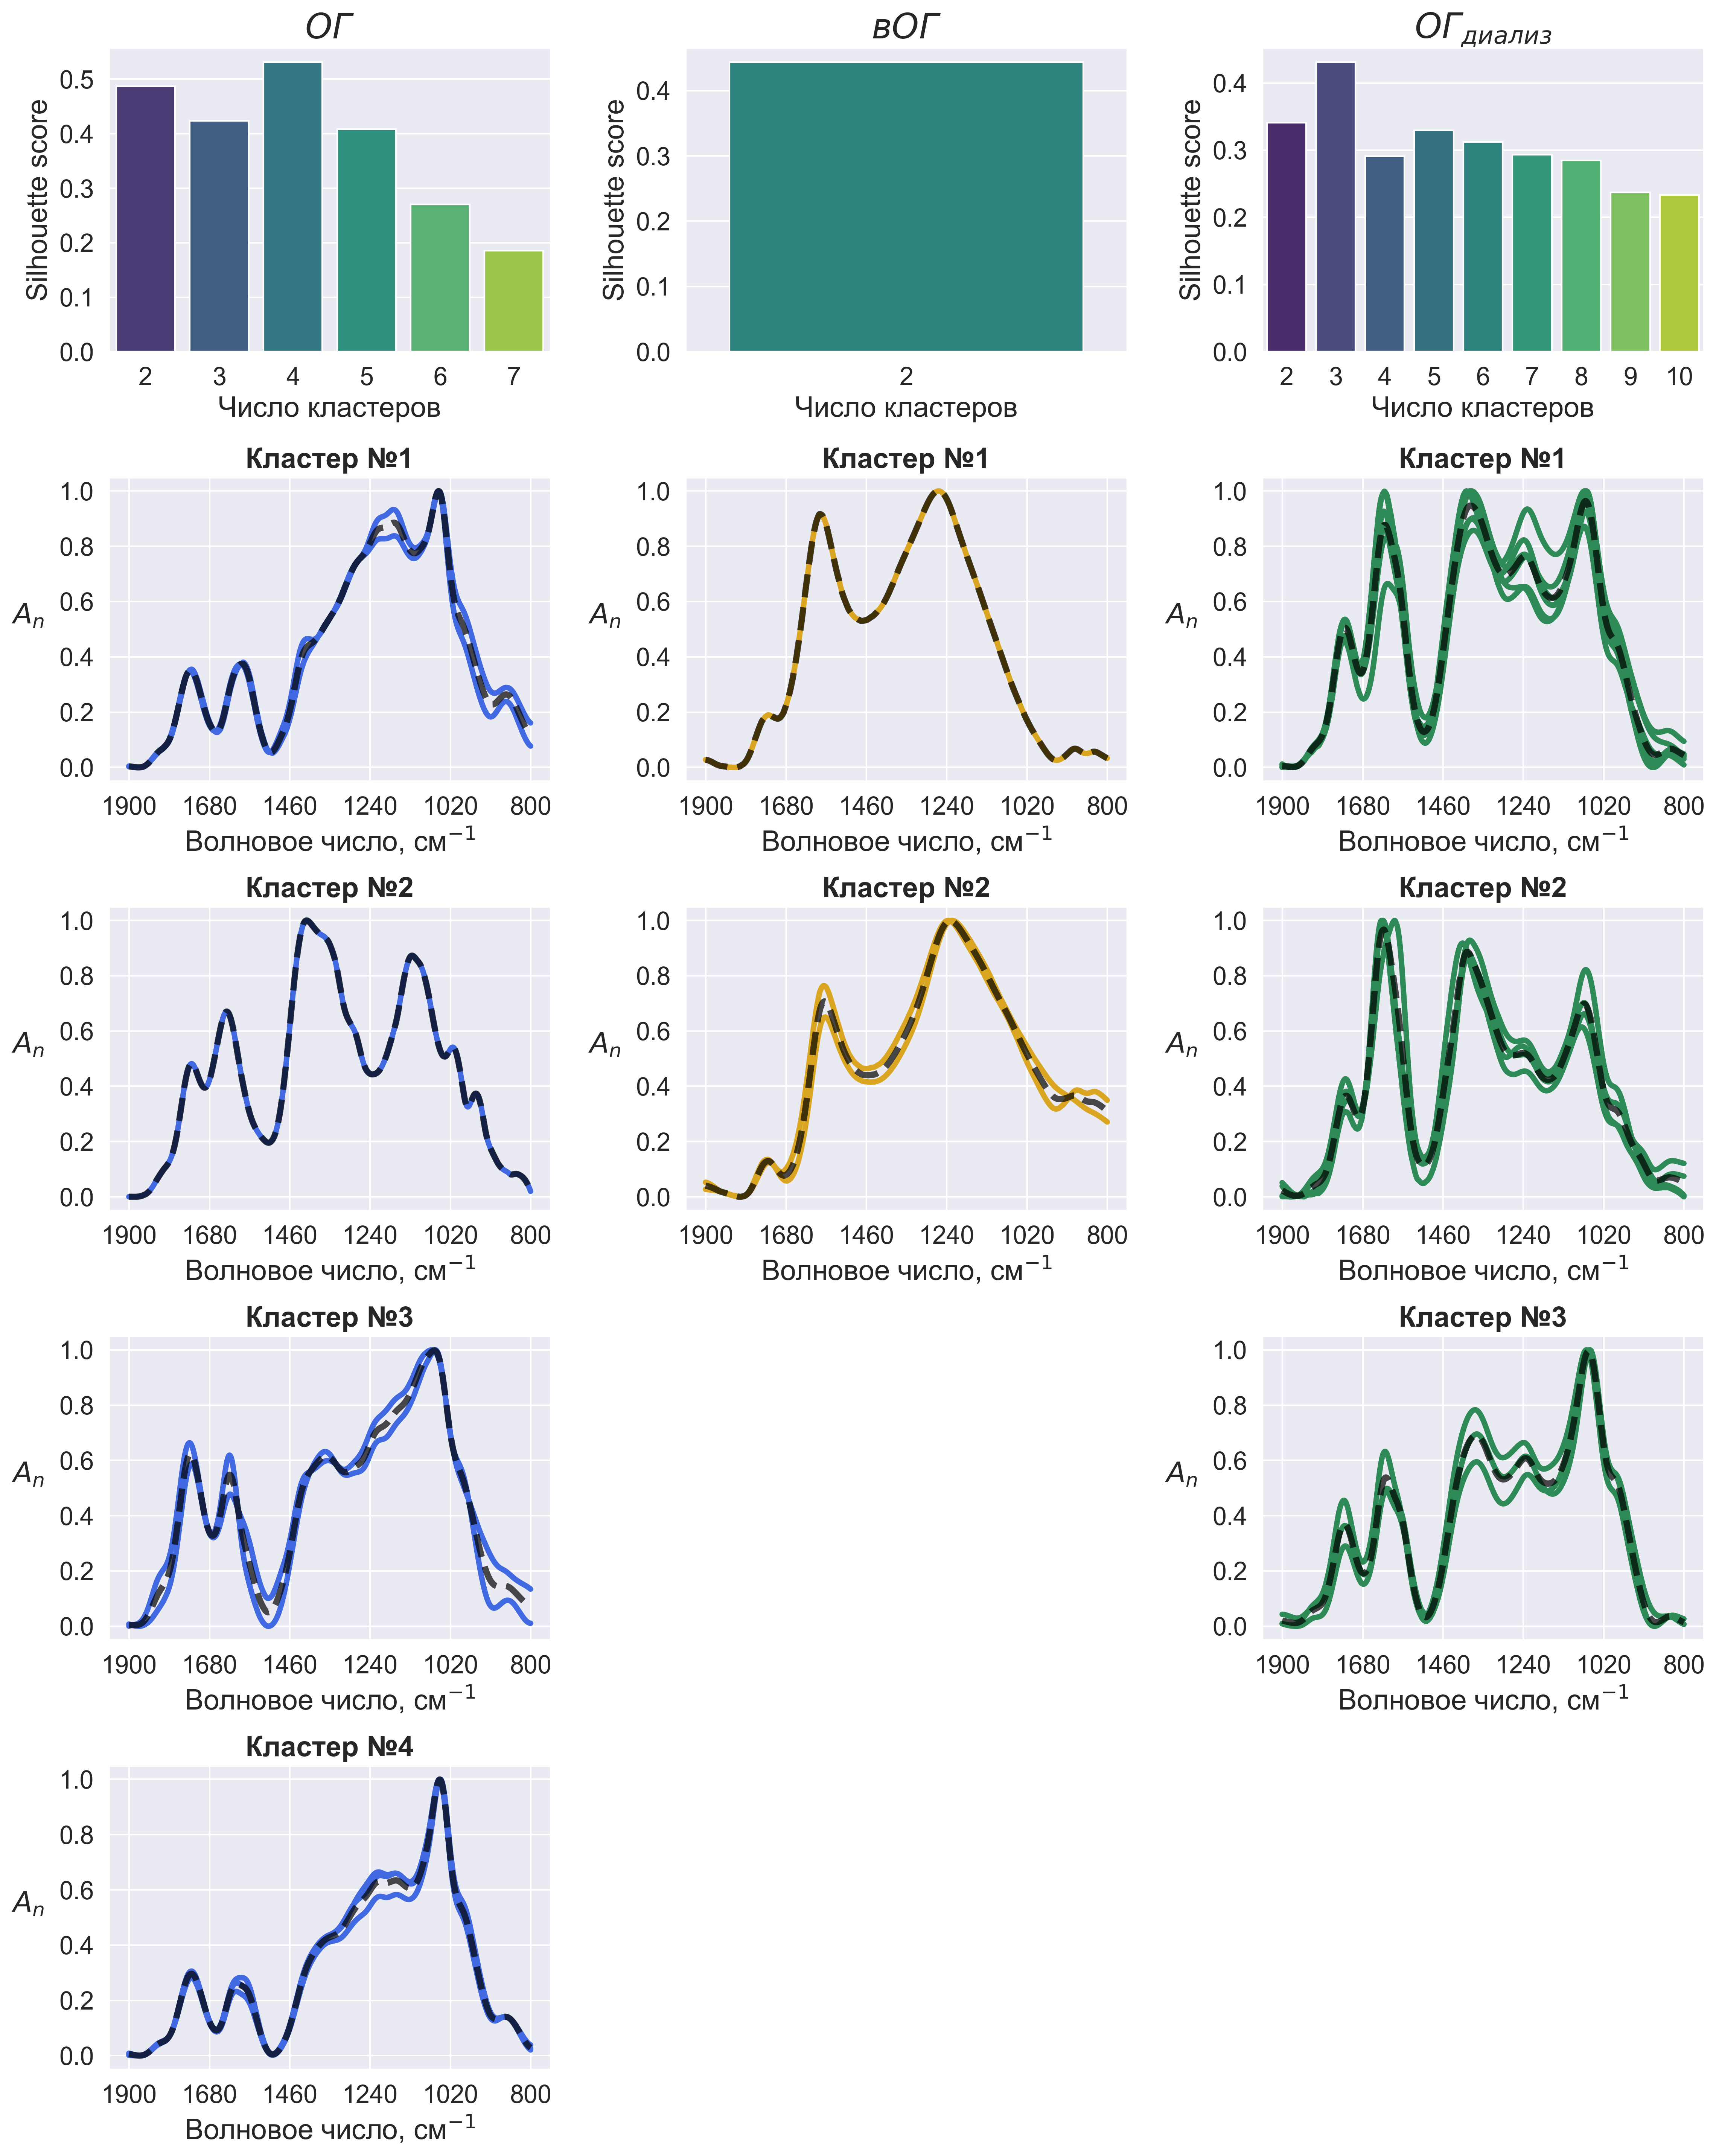

In [25]:
sns.set_theme()

max_clusters = max([d[4] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(15.5, 3.85 * fig_rows), dpi=300, constrained_layout=True)

for i, (label, embeddings, original_data, color, n_clusters) in enumerate(datasets):
    analyzer = EmbeddingStructureAnalysis(model)

    analyzer.fit_transform_kmeans(embeddings, n_clusters)

    analyzer.get_metrics_visualization(embeddings, max_n_clusters=max_n_clusters, ax=axes[0, i], refit=False)

    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE)

    sub_axes = axes[1:analyzer.n_clusters+1, i]
    
    analyzer.get_spectra_clusters_visualization(original_data=original_data, wavenumber=wavenumber, axes=sub_axes, color=color)

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][4] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig(f'{path_to_save}/clustering_results.png', dpi=600)

plt.show()

## Analytics of results

In [26]:
results_df = pd.DataFrame()

for predictions_df in predictions_lst:
    tmp_description_prediction_df = pd.merge(
        left=predictions_df['Prediction'],
        right=samples_description[['Type', 'Description']],
        left_index=True,
        right_index=True
    )

    results_df = pd.concat([results_df, tmp_description_prediction_df], axis=0)

results_df = results_df[['Type', 'Description', 'Prediction']].sort_values(by=['Type', 'Prediction', 'Description'])

results_df

,Type,Description,Prediction
3,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",0
13,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",0
2,$GO$,"HGO, 0.0116 г в 25 мл H2O",1
12,$GO$,"GO, USA, 0.1 г в 100 мл H2O",2
1,$GO$,"MFGO, разб. 1:20",2
9,$GO$,"GO, RusGraphene, 1.00 г в 250 мл H2O",3
11,$GO$,"GO, RusGraphene, 1.00 г в 250 мл H2O",3
8,$GO$,"GO, RusGraphene, 2 г в 1000 мл H2O",3
31,$GO_{d}$,"Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М",0
20,$GO_{d}$,"Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М",0


## Adhoc visualization

In [27]:
max_n_clusters = 10

embedding_go = EmbeddingStructureAnalysis(model).get_embedding(go_data_torch, go_data)
embedding_rgo = EmbeddingStructureAnalysis(model).get_embedding(rgo_data_torch, rgo_data)
embedding_god = EmbeddingStructureAnalysis(model).get_embedding(god_data_torch, god_data)

datasets = [
    ('$GO$', embedding_go, go_data, 'RoyalBlue', 4),
    ('$rGO$', embedding_rgo, rgo_data, 'Goldenrod', 2),
    ('$GO_{d}$', embedding_god, god_data, 'SeaGreen', 3)
]

predictions_lst = []

Computing silhouette values: 100%|████████████████| 9/9 [00:00<00:00, 51.85it/s]


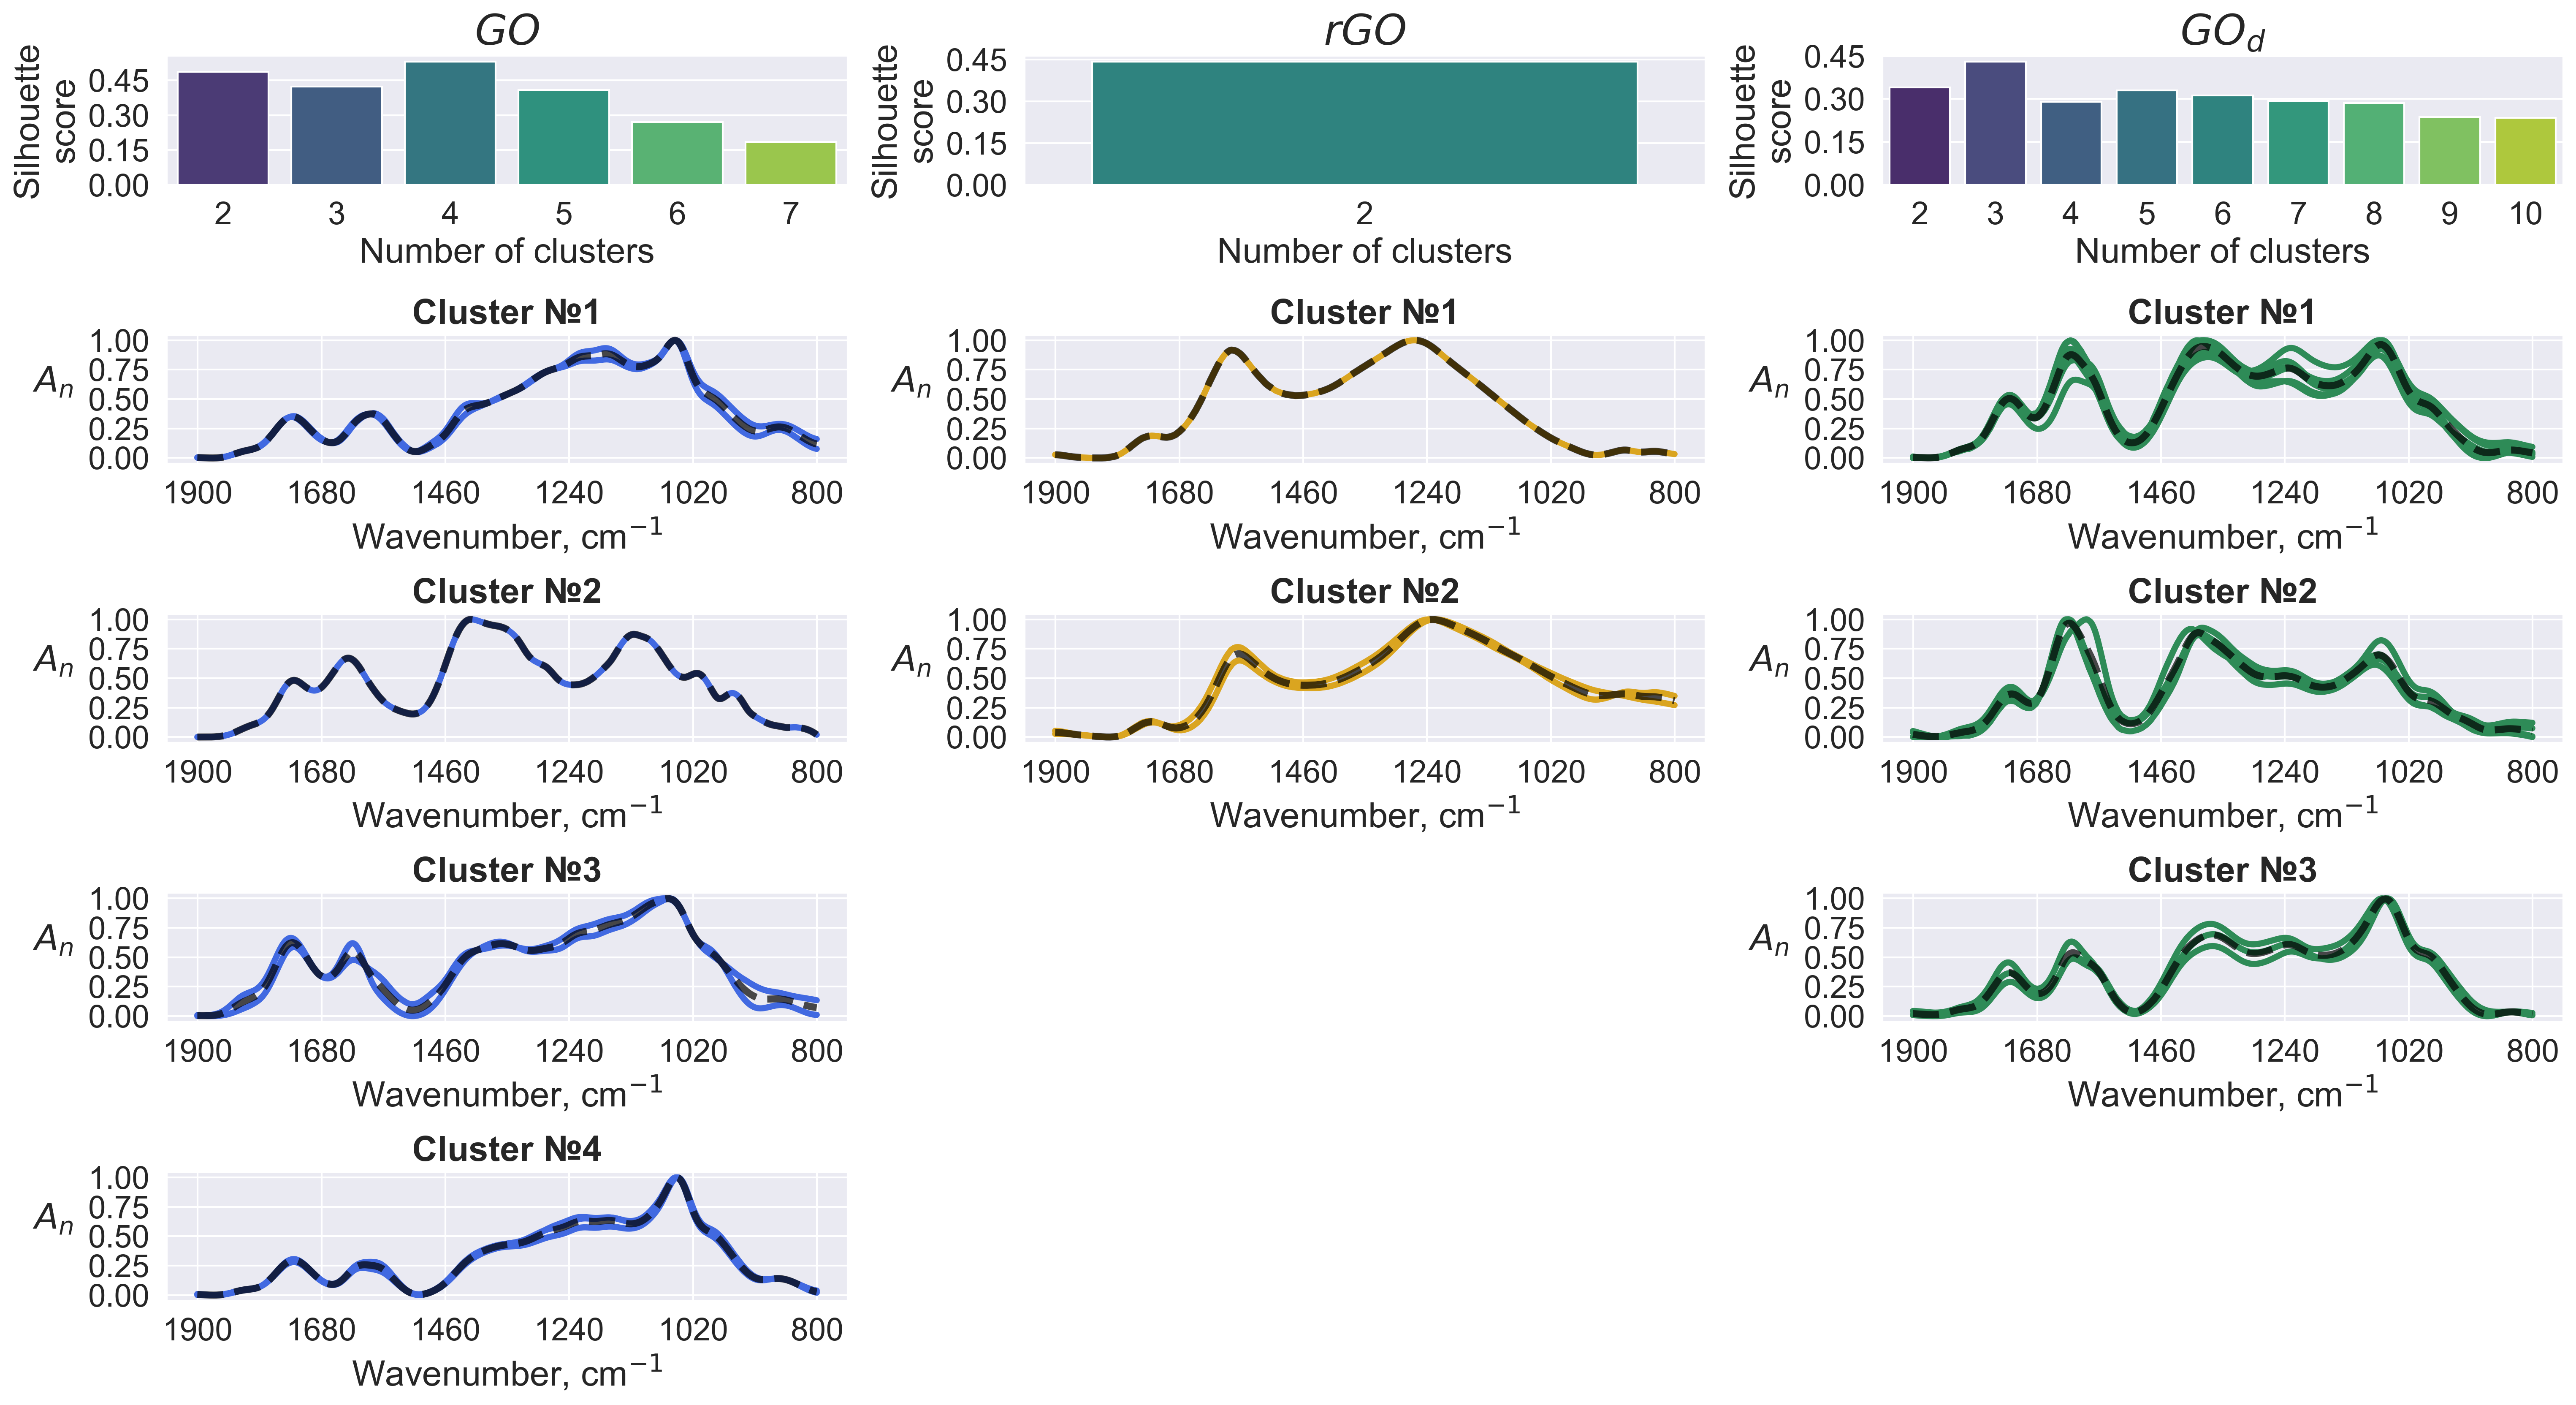

In [28]:
sns.set_theme()

max_clusters = max([d[4] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(20.5, 2.25 * fig_rows), dpi=300, constrained_layout=True)

for i, (label, embeddings, original_data, color, n_clusters) in enumerate(datasets):
    analyzer = EmbeddingStructureAnalysis(model)

    analyzer.fit_transform_kmeans(embeddings, n_clusters)

    analyzer.get_metrics_visualization(embeddings, max_n_clusters=max_n_clusters, ax=axes[0, i], refit=False)

    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE+2)
    
    axes[0, i].set_xlabel(f'Number of clusters', fontsize=FONT_SIZE_XLABEL+2)
    axes[0, i].set_ylabel(f'Silhouette\nscore', fontsize=FONT_SIZE_YLABEL+2)

    axes[0, i].tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
    axes[0, i].tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
    
    axes[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.15))

    sub_axes = axes[1:analyzer.n_clusters+1, i]

    analyzer.get_spectra_clusters_visualization(original_data=original_data, wavenumber=wavenumber, axes=sub_axes, color=color)

    for i, ax in enumerate(sub_axes):
        ax.set_title(f'Cluster №{i+1}', fontsize=FONT_SIZE_TITLE-2, fontweight='bold')
        
        ax.set_xlabel('Wavenumber, cm$^{-1}$', fontsize=FONT_SIZE_XLABEL+2)
        ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL+2)

        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][4] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig(f'{path_to_save}/adhoc_clustering_results.png', dpi=600)

plt.show()